### Conexión a la BD de RDS

In [1]:
import datetime
import missingno as msno
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.model_selection import GridSearchCV

from sqlalchemy import create_engine, text

#maximum number of rows to display
pd.options.display.max_rows = 20

DB_USERNAME = 'damjimenezgu'
DB_PASSWORD = 'Analista1!' 
DB_ENDPOINT = 'ds4a-demo-instance.cqjr4hyu9xaq.us-east-1.rds.amazonaws.com' 
DB_NAME = 'desertion_pj_team67' 

engine=create_engine(f'postgresql://{DB_USERNAME}:{DB_PASSWORD}@{DB_ENDPOINT}/{DB_NAME}', max_overflow=20)

def runQuery(sql):
    result = engine.connect().execution_options(isolation_level="AUTOCOMMIT").execute((text(sql)))
    return pd.DataFrame(result.fetchall(), columns=result.keys())

### Pasar datos de RDS a pandas dataframe

In [2]:
mun = runQuery("""
select * from master_table_by_municipio where year_cohort = 2019 and desertion_perc is not null;""")

 ### Revisar datos faltantes

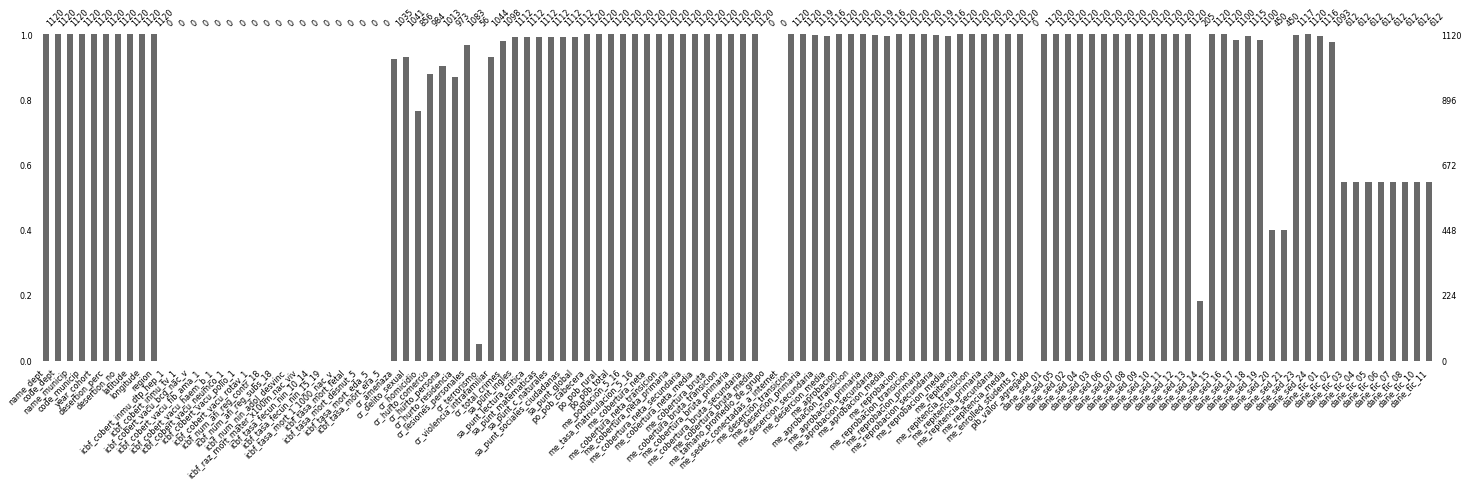

In [3]:
msno.bar(mun, labels=True, figsize=(25,6), fontsize=8)

In [6]:
def full_describe(dataframe,variables="all",variabilidad=20,completitud=10): #summary, univariado, describe, analisis descriptivo, describir, analisis exploratorio
    #Descripcion de los parametros:
    #dataframe: Tabla a usar en formato DataFrame
    #variables: variables sobre las que se va a calcular el describe. Formas posibles: "all", ingresar secuencia (ie. '1:8'), 
    #ingresar lista de numeros o de nombres de variables (ie. '1,4,9' o 'var1,var2,var3')
    #completitud: Minimo de completitud aceptada por variable (valor entre 0 y 100)
    #variabilidad: Minimo de variabilidad aceptada por variable (0,2,10,20,50,100)
    print("Inicia calculo del describe, Hora: "+ datetime.datetime.now().strftime("%H:%M:%S"))
    start1 = datetime.datetime.now()
    if variables == "all": #Si se desea analisis para todas las variables
        #Calcular describe y adicionar (concatenar) filas con Missing
        resumen=pd.concat([dataframe.describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.isnull().sum().to_frame(name = 'missing').T],sort=False)
    elif ":" in variables: #Si se desea analisis para secuencia de variables n1:n2
        #Calcular describe y adicionar (concatenar) filas con Missing
        variables_serie=list(pd.to_numeric((variables).split(':')))
        variables_serie=list(pd.Series(range(variables_serie[0],variables_serie[1])))
        resumen=pd.concat([dataframe.iloc[:,variables_serie].describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.iloc[:,variables_serie].isnull().sum().to_frame(name = 'missing').T],sort=False)
    else:
        try: #Si se desea analisis para array numerico (posiciones) de variables [n1,n2,n3,...]
            # Dividir valor de variables por coma, creando lista numerica
            variables_serie=list(pd.to_numeric((variables).split(',')))
            #Calcular describe y adicionar (concatenar) filas con Missing
            resumen=pd.concat([dataframe.iloc[:,variables_serie].describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.iloc[:,variables_serie].isnull().sum().to_frame(name = 'missing').T],sort=False)
        except: 
            if set(list(variables.split(","))).issubset(list(dataframe.columns)): #Si se desea analisis para array string (nombres de campos) de variables ['nom1','nom2','nom3',...]
                # Dividir valor de variables por coma, creando lista de cadena de texto
                variables_serie=list(variables.split(","))
                #Calcular describe y adicionar (concatenar) filas con Missing
                resumen=pd.concat([dataframe.loc[:,variables_serie].describe(include="all",percentiles =[0,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]), dataframe.loc[:,variables_serie].isnull().sum().to_frame(name = 'missing').T],sort=False)
            else: #Garbage Collector para casos diferentes
                resumen="Invalid entry for variables"
                
    print("Finaliza calculo del describe. Tiempo transcurrido: "+str((datetime.datetime.now() - start1).seconds)+" segs")
    
    start2 = datetime.datetime.now()
    print("Inicia calculo de completitud y variabilidad, Hora: "+ datetime.datetime.now().strftime("%H:%M:%S"))
    if isinstance(resumen, pd.DataFrame)==True: #Verificar si existe algun error en los parametros ingresados
        #Calcular cantidad total
        resumen.loc['total count']=resumen.loc[['count','missing']].sum()
        #Calcular porcentaje de missing
        resumen.loc['% missing']=np.around((resumen.loc['missing']*100/resumen.loc['total count']).astype(np.double),4)
        #Trasponer para usar de mejor forma el codigo
        resumen=resumen.T
        #Calcular variabilidad
        resumen['variabilidad'] = np.where(resumen['min']==resumen['max'], '00_variacion', 
                                           np.where(resumen['1%']==resumen['99%'], '02_variacion', 
                                                   np.where(resumen['5%']==resumen['95%'], '10_variacion', 
                                                           np.where(resumen['10%']==resumen['90%'], '20_variacion', 
                                                                   np.where(resumen['25%']==resumen['75%'], '50_variacion', 
                                                                           'variabilidad_alta')))))
        if variabilidad == 0:
            resumen['decision_variabilidad'] = "aceptar"
        elif variabilidad == 2:
            resumen['decision_variabilidad'] = np.where(resumen['variabilidad']=='00_variacion', 'rechazar',
                                                        'aceptar')
        elif variabilidad == 10:
            resumen['decision_variabilidad'] = np.where((resumen['variabilidad']=='00_variacion') | (resumen['variabilidad']=='02_variacion'), 'rechazar',
                                                        'aceptar')
        elif variabilidad == 20:
            resumen['decision_variabilidad'] = np.where((resumen['variabilidad']=='00_variacion') | (resumen['variabilidad']=='02_variacion') | (resumen['variabilidad']=='10_variacion'), 'rechazar',
                                                        'aceptar')
        elif variabilidad == 50:
            resumen['decision_variabilidad'] = np.where((resumen['variabilidad']=='00_variacion') | (resumen['variabilidad']=='02_variacion') | (resumen['variabilidad']=='10_variacion') | (resumen['variabilidad']=='20_variacion'), 'rechazar',
                                                        'aceptar')
        elif variabilidad == 100: 
            resumen['decision_variabilidad'] = np.where((resumen['variabilidad']=='00_variacion') | (resumen['variabilidad']=='02_variacion') | (resumen['variabilidad']=='10_variacion') | (resumen['variabilidad']=='20_variacion') | (resumen['variabilidad']=='50_variacion'), 'rechazar',
                                                        'aceptar')
        else:
            resumen['decision_variabilidad']="VALOR NO VALIDO"
            print("Invalid entry for parameter variabilidad")
        #Calcular completitud
        resumen['decision_completitud']=np.where(resumen['% missing']==0,'aceptar_100',
                                                 np.where(resumen['% missing']>completitud, 'rechazar','aceptar')) 
    else:
        resumen="Invalid entry for variables"
        
    print("Finaliza calculo de completitud y variabilidad. Tiempo transcurrido: "+str((datetime.datetime.now() - start2).seconds)+" segs")
    
    
    print("Finaliza calculo del proceso completo. Tiempo transcurrido total: "+str((datetime.datetime.now() - start1).seconds)+" segs")
    return resumen

In [7]:
#Invocar funcion
resumen=full_describe(dataframe=mun,variabilidad=20,completitud=30)
resumen.to_clipboard(index=True,header=True)

Inicia calculo del describe, Hora: 21:12:54
Finaliza calculo del describe. Tiempo transcurrido: 0 segs
Inicia calculo de completitud y variabilidad, Hora: 21:12:55
Finaliza calculo de completitud y variabilidad. Tiempo transcurrido: 0 segs
Finaliza calculo del proceso completo. Tiempo transcurrido total: 0 segs


### Imputar valores faltantes

In [8]:
#Mantener solo columnas con bajo % de missing
mun_nomiss=mun.copy()

vars_drop = list(['cr_terrorismo','icbf_cobert_inmu_dtp_hep_1','icbf_cobert_inmu_tv_1','icbf_cobert_vacu_bcg_nac_v','icbf_cobert_vacu_fib_ama_1','icbf_cobert_vacu_haem_b_1','icbf_cobert_vacu_neumco_1','icbf_cobert_vacu_polio_1','icbf_cobert_vacu_rotav_1','icbf_num_afi_reg_contr_18','icbf_num_afi_reg_subs_18','icbf_num_nin_adol_desvinc','icbf_raz_mort_mater_x100m_nac_viv','icbf_tasa_fecun_nin_10_14','icbf_tasa_fecun_nin_15_19','icbf_tasa_mort_1_1000_nac_v','icbf_tasa_mort_fetal','icbf_tasa_mort_desnut_5','icbf_tasa_mort_eda_5','icbf_tasa_mort_era_5','me_tamano_promedio_de_grupo','me_sedes_conectadas_a_internet','pib_valor_agregado','dane_tic_11','dane_sed_20','dane_sed_21','dane_sed_14'])
mun_nomiss.drop(vars_drop, axis=1, inplace=True)
mun_nomiss.shape

#Por ahora se imputan los valores faltantes usando la mediana de cada variable. 
#Se debe evaluar si es la mejor forma de imputación o se debe usar otra
mun_nomiss=mun_nomiss.fillna(mun_nomiss.median())

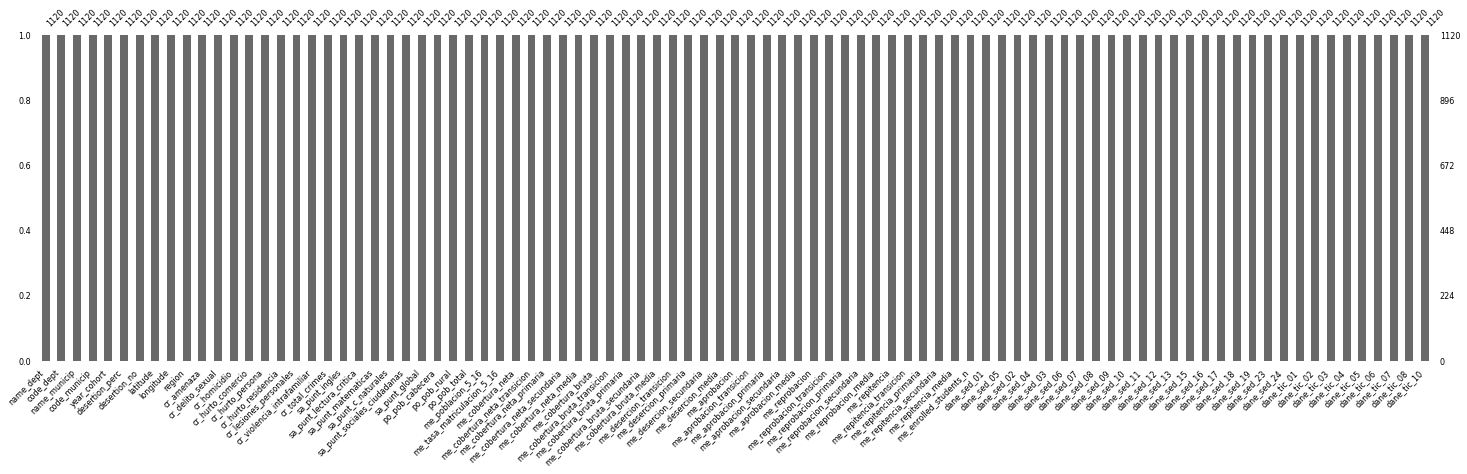

In [9]:
msno.bar(mun_nomiss, labels=True, figsize=(25,6), fontsize=8)

### Inspeccionar valores atipicos

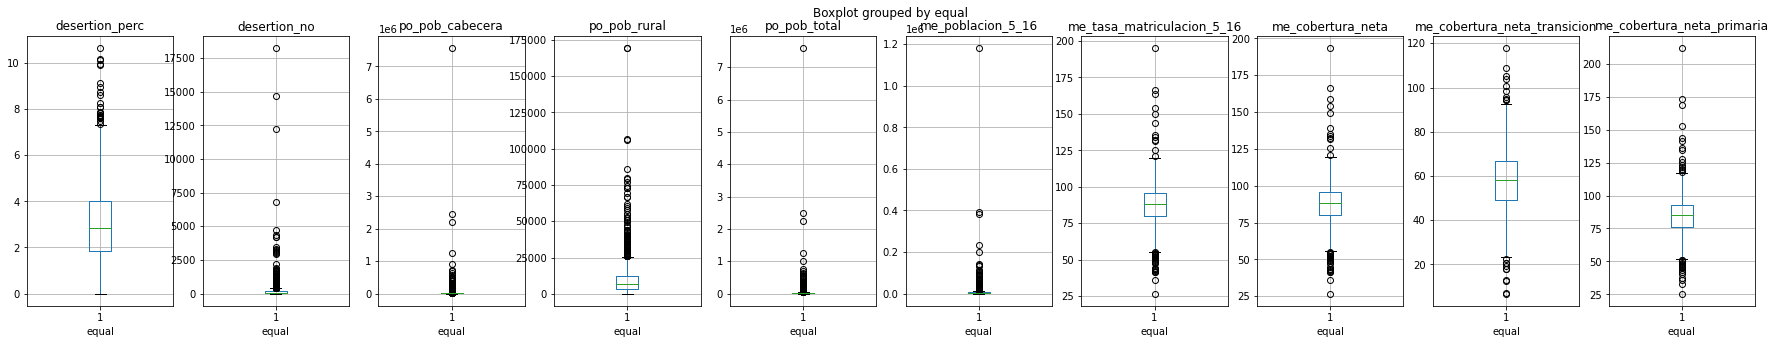

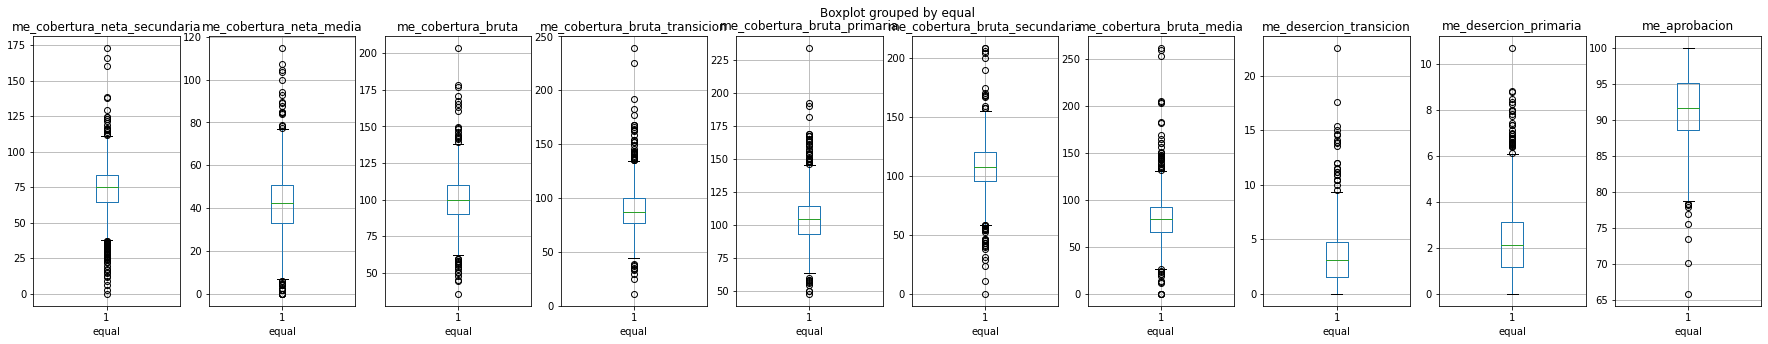

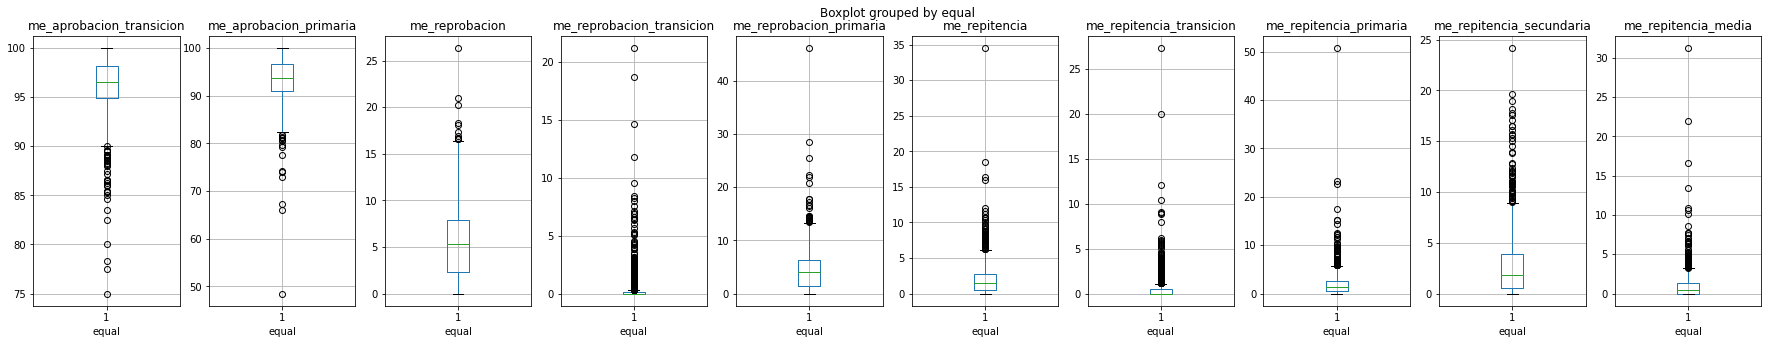

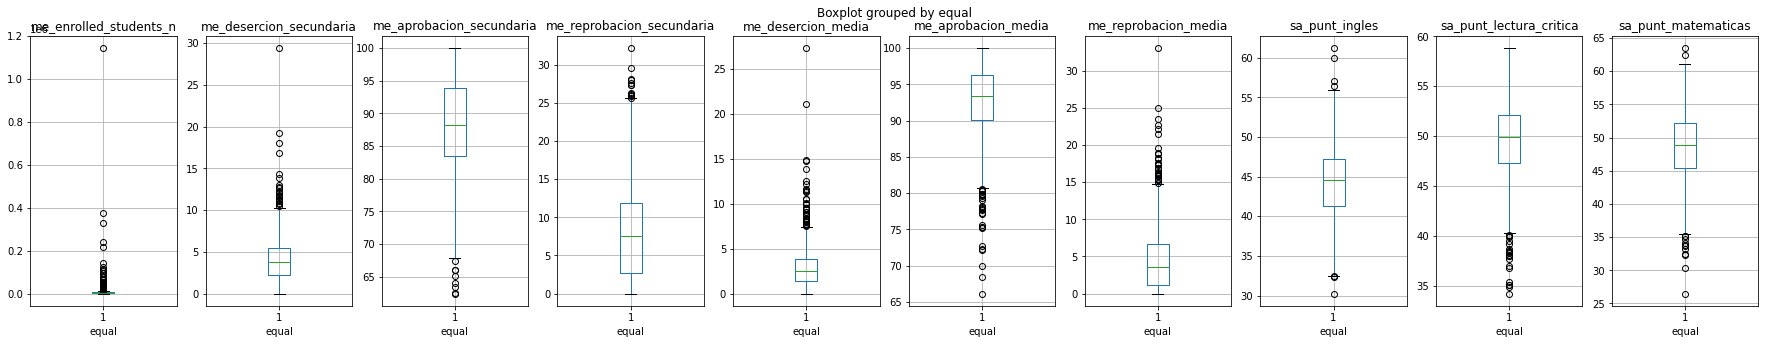

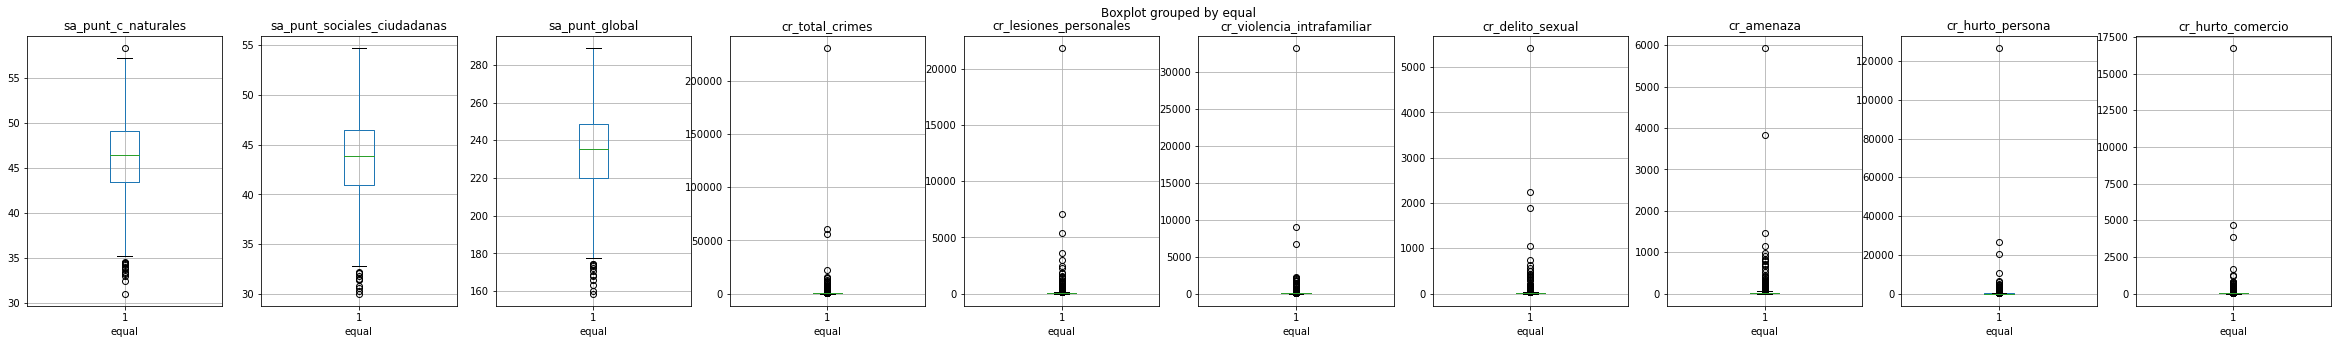

In [10]:
vars_boxplot=list(['desertion_perc','desertion_no','po_pob_cabecera','po_pob_rural','po_pob_total','me_poblacion_5_16','me_tasa_matriculacion_5_16','me_cobertura_neta','me_cobertura_neta_transicion','me_cobertura_neta_primaria','me_cobertura_neta_secundaria','me_cobertura_neta_media','me_cobertura_bruta','me_cobertura_bruta_transicion','me_cobertura_bruta_primaria','me_cobertura_bruta_secundaria','me_cobertura_bruta_media','me_desercion_transicion','me_desercion_primaria','me_aprobacion','me_aprobacion_transicion','me_aprobacion_primaria','me_reprobacion','me_reprobacion_transicion','me_reprobacion_primaria','me_repitencia','me_repitencia_transicion','me_repitencia_primaria','me_repitencia_secundaria','me_repitencia_media','me_enrolled_students_n','me_desercion_secundaria','me_aprobacion_secundaria','me_reprobacion_secundaria','me_desercion_media','me_aprobacion_media','me_reprobacion_media','sa_punt_ingles','sa_punt_lectura_critica','sa_punt_matematicas','sa_punt_c_naturales','sa_punt_sociales_ciudadanas','sa_punt_global','cr_total_crimes','cr_lesiones_personales','cr_violencia_intrafamiliar','cr_delito_sexual','cr_amenaza','cr_hurto_persona','cr_hurto_comercio','cr_hurto_residencia','cr_homicidio'])
#vars_boxplot=list(['desertion_perc','desertion_no','po_pob_cabecera','po_pob_rural'])
mun_nomiss['equal']=1

fig, ax = plt.subplots(1, 10, figsize=(30, 5))
for i in range(0, 10):
    mun_nomiss.boxplot(vars_boxplot[i],'equal', ax=ax[i])    
fig, ax = plt.subplots(1, 10, figsize=(30, 5))
for i in range(0, 10):
    mun_nomiss.boxplot(vars_boxplot[i+10],'equal', ax=ax[i])    
fig, ax = plt.subplots(1, 10, figsize=(30, 5))
for i in range(0, 10):
    mun_nomiss.boxplot(vars_boxplot[i+20],'equal', ax=ax[i])    
fig, ax = plt.subplots(1, 10, figsize=(30, 5))
for i in range(0, 10):
    mun_nomiss.boxplot(vars_boxplot[i+30],'equal', ax=ax[i])    
fig, ax = plt.subplots(1, 10, figsize=(40, 5))
for i in range(0, 10):
    mun_nomiss.boxplot(vars_boxplot[i+40],'equal', ax=ax[i])

### Acotar variables por valores atípicos (percentiles 5 y 95)

In [11]:
percentile_df = mun_nomiss.set_index(['name_dept', 'code_dept', 'name_municip', 'code_municip', 'year_cohort', 'latitude', 'longitude', 'region']).apply(lambda x: np.clip(x, *np.percentile(x, [5,95]))).reset_index()

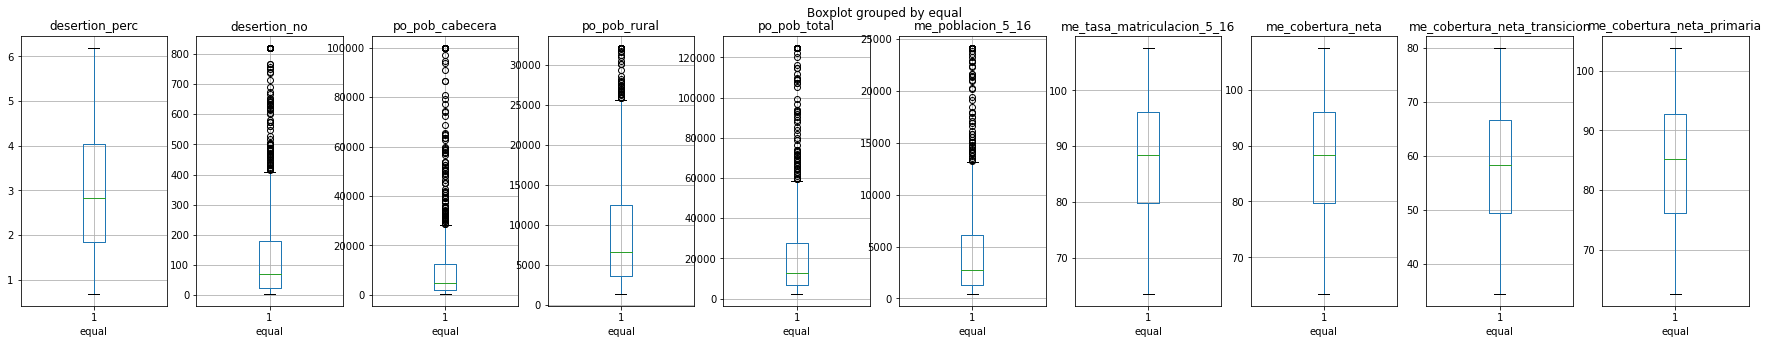

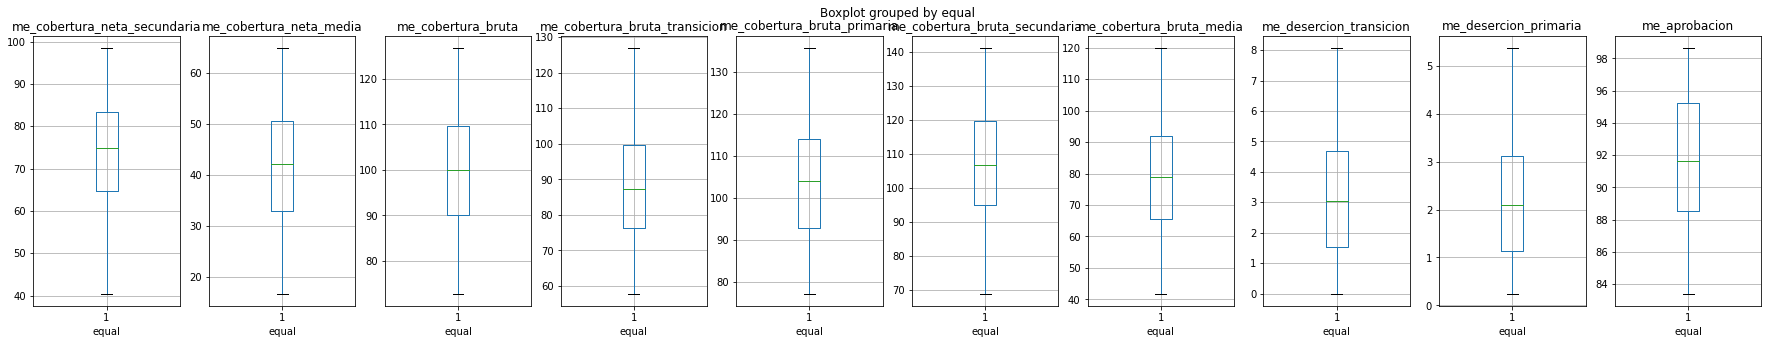

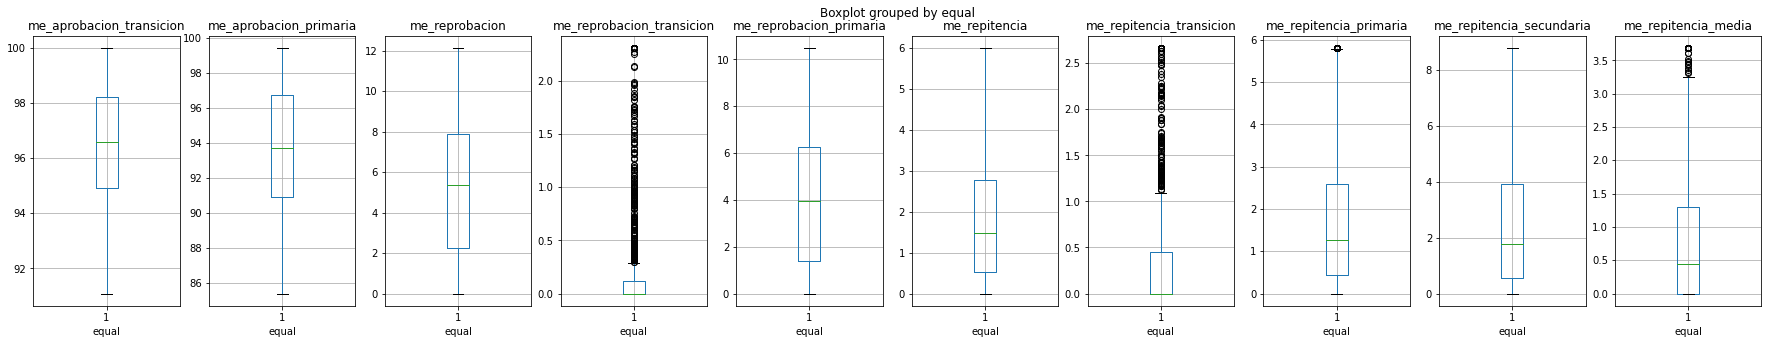

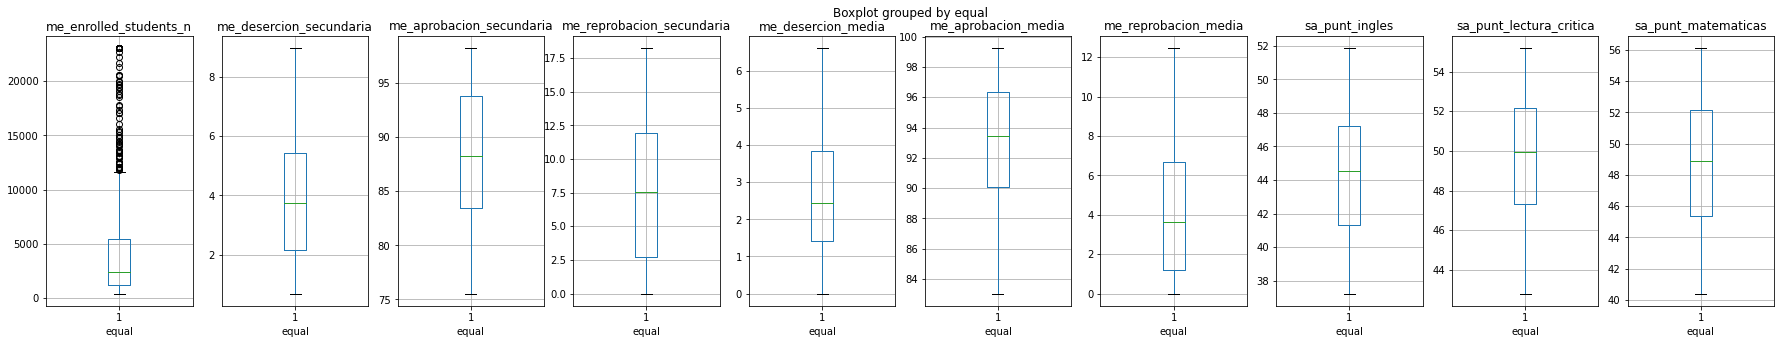

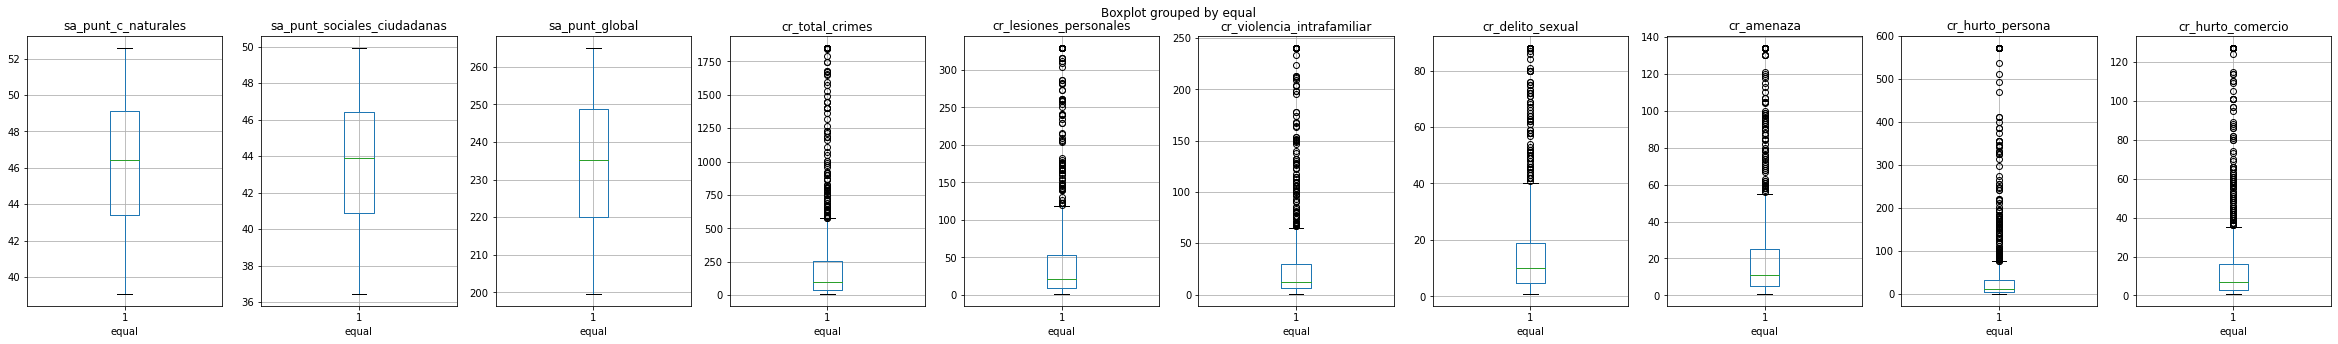

In [12]:
fig, ax = plt.subplots(1, 10, figsize=(30, 5))
for i in range(0, 10):
    percentile_df.boxplot(vars_boxplot[i],'equal', ax=ax[i])    
fig, ax = plt.subplots(1, 10, figsize=(30, 5))
for i in range(0, 10):
    percentile_df.boxplot(vars_boxplot[i+10],'equal', ax=ax[i])    
fig, ax = plt.subplots(1, 10, figsize=(30, 5))
for i in range(0, 10):
    percentile_df.boxplot(vars_boxplot[i+20],'equal', ax=ax[i])    
fig, ax = plt.subplots(1, 10, figsize=(30, 5))
for i in range(0, 10):
    percentile_df.boxplot(vars_boxplot[i+30],'equal', ax=ax[i])    
fig, ax = plt.subplots(1, 10, figsize=(40, 5))
for i in range(0, 10):
    percentile_df.boxplot(vars_boxplot[i+40],'equal', ax=ax[i])

### Rankear deserción usando Kmeans (Alto, Medio, Bajo)

In [13]:
mun_nomiss.columns

Index(['name_dept', 'code_dept', 'name_municip', 'code_municip', 'year_cohort',
       'desertion_perc', 'desertion_no', 'latitude', 'longitude', 'region',
       'cr_amenaza', 'cr_delito_sexual', 'cr_homicidio', 'cr_hurto_comercio',
       'cr_hurto_persona', 'cr_hurto_residencia', 'cr_lesiones_personales',
       'cr_violencia_intrafamiliar', 'cr_total_crimes', 'sa_punt_ingles',
       'sa_punt_lectura_critica', 'sa_punt_matematicas', 'sa_punt_c_naturales',
       'sa_punt_sociales_ciudadanas', 'sa_punt_global', 'po_pob_cabecera',
       'po_pob_rural', 'po_pob_total', 'me_poblacion_5_16',
       'me_tasa_matriculacion_5_16', 'me_cobertura_neta',
       'me_cobertura_neta_transicion', 'me_cobertura_neta_primaria',
       'me_cobertura_neta_secundaria', 'me_cobertura_neta_media',
       'me_cobertura_bruta', 'me_cobertura_bruta_transicion',
       'me_cobertura_bruta_primaria', 'me_cobertura_bruta_secundaria',
       'me_cobertura_bruta_media', 'me_desercion_transicion',
       'me_de

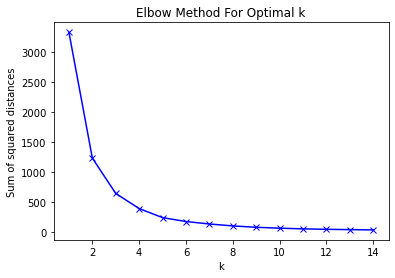

In [14]:
#Usar solo la desercion
desertion=pd.DataFrame(mun_nomiss['desertion_perc'])
#Número de cluster óptimo
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=12345)
    km = km.fit(desertion)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

C:\Users\Daniel_Jimenez\Documents\programas_Data_science\Anaconda\envs\desertion_project\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


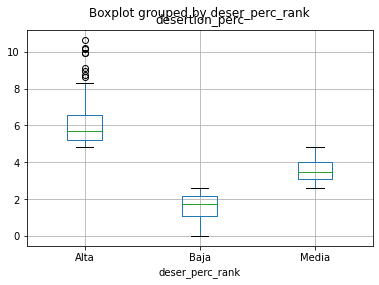

In [15]:
#Ajustar Kmeans con 3 grupos
km = KMeans(n_clusters=3, random_state=12345).fit(desertion)
mun_nomiss['deser_perc_rank']=km.labels_
mun_nomiss['deser_perc_rank']=np.where(mun_nomiss['deser_perc_rank'] == 1, 'Baja'
                                       , np.where(mun_nomiss['deser_perc_rank'] == 0, 'Media','Alta'))
mun_nomiss.boxplot('desertion_perc','deser_perc_rank')

# Ajuste de árbol de decisión 
### Feature selection

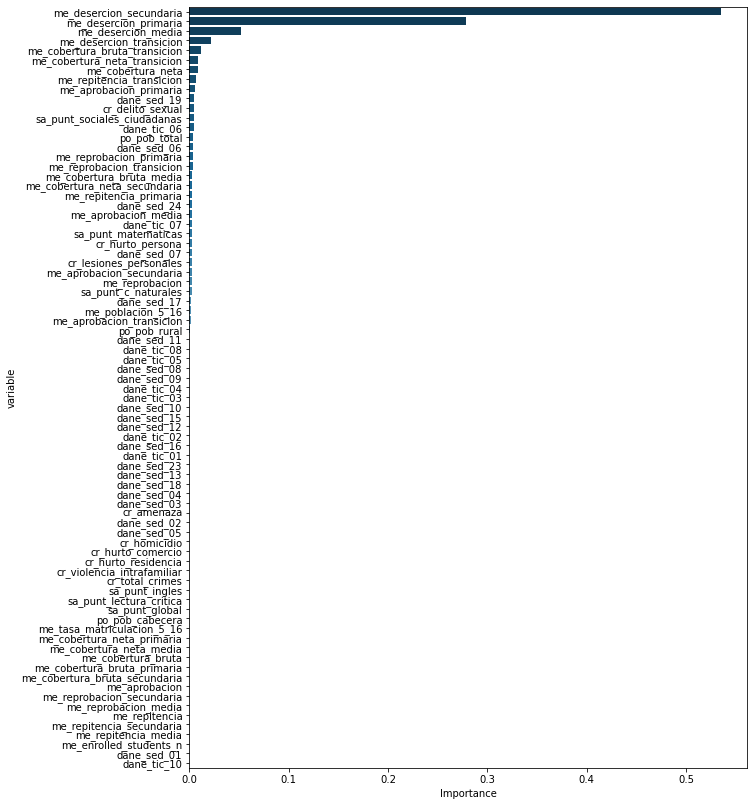

In [19]:
vars_drop = list(['name_dept', 'code_dept', 'name_municip', 'code_municip', 'year_cohort',
       'desertion_perc', 'desertion_no', 'latitude', 'longitude', 'region','equal','deser_perc_rank'])
X_all=mun_nomiss.drop(vars_drop, axis=1)

y=mun_nomiss['deser_perc_rank']

clf = DecisionTreeClassifier(random_state=12345)
clf = clf.fit(X_all, y)
features_imp=dict(zip(X_all.columns, clf.feature_importances_))
features_imp=pd.DataFrame.from_dict(features_imp, orient='index').reset_index()
features_imp.rename(columns={'index':'variable',0:'Importance'},inplace=True)
features_imp=features_imp.sort_values(by='Importance', ascending=False)
features_imp.to_clipboard(index=False,header=True)

plt.figure(figsize=(10,14))
ax = sns.barplot(x="Importance", y="variable", data=features_imp,palette="PuBu_r")

### Ajuste del modelo

In [21]:
feature_cols = ['me_desercion_secundaria','me_desercion_primaria','me_desercion_media','me_desercion_transicion','me_cobertura_bruta_transicion']
X = X_all[feature_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train,y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print("Accuracy train:",metrics.accuracy_score(y_train, y_pred_train))
print("Accuracy test:",metrics.accuracy_score(y_test, y_pred_test))
print("Recall (Sensitivity) train:",metrics.recall_score(y_train, y_pred_train, average=None))
print("Recall (Sensitivity) test:",metrics.recall_score(y_test, y_pred_test, average=None))
print("F1 Score train:",metrics.f1_score(y_train, y_pred_train, average=None))
print("F1 Score test:",metrics.f1_score(y_test, y_pred_test, average=None))
pd.DataFrame(metrics.confusion_matrix(y_pred_test,y_test)).to_clipboard(index=True,header=True)

Accuracy train: 0.8872767857142857
Accuracy test: 0.8794642857142857
Recall (Sensitivity) train: [0.68613139 0.99002494 0.84916201]
Recall (Sensitivity) test: [0.66666667 0.96039604 0.86021505]
F1 Score train: [0.79661017 0.93742621 0.85754584]
F1 Score test: [0.78431373 0.92380952 0.85561497]


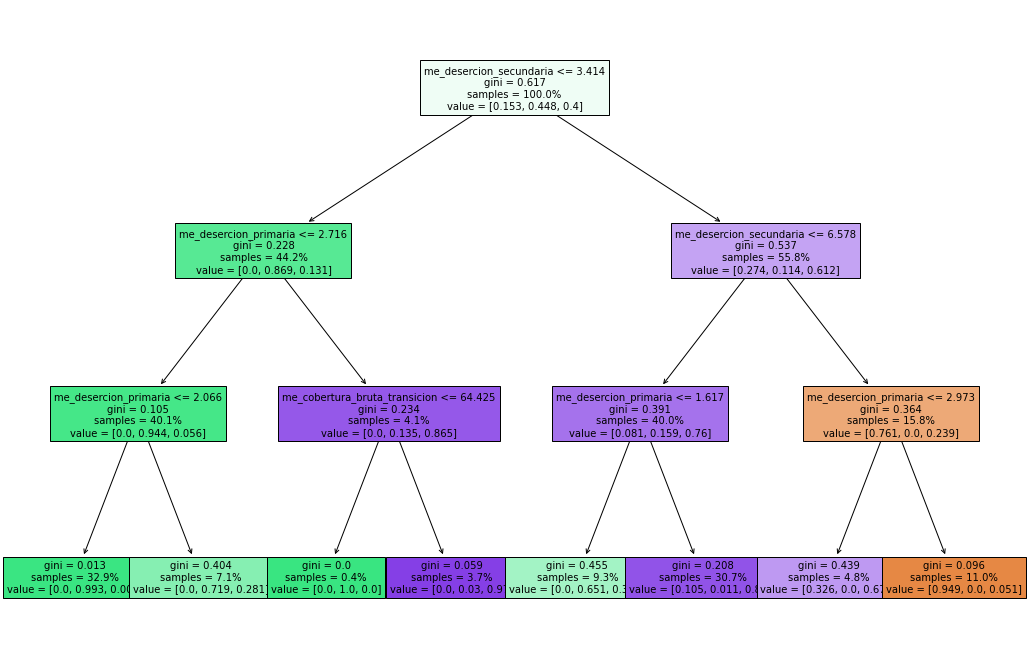

In [22]:
fig, ax = plt.subplots(figsize=(18, 12))
tree.plot_tree(clf, max_depth=4, fontsize=10,feature_names=feature_cols,filled=True,proportion=True)
plt.show()

### Caracterización

In [23]:
categ=np.floor(X[X.columns].rank() / len(X) / .3).astype(int) + 1
categ.columns = [str(col) + '_cat' for col in categ.columns]
result = pd.concat([X, categ], axis=1, sort=False)
result=pd.concat([result, pd.DataFrame(y)], axis=1, sort=False)
result

,me_desercion_secundaria,me_desercion_primaria,me_desercion_media,me_desercion_transicion,me_cobertura_bruta_transicion,me_desercion_secundaria_cat,me_desercion_primaria_cat,me_desercion_media_cat,me_desercion_transicion_cat,me_cobertura_bruta_transicion_cat,deser_perc_rank
0,5.2982,3.1019,2.6897,3.6600,94.8486,3,3,2,3,3,Media
1,4.9600,1.8908,3.9813,2.6786,81.7518,3,2,3,2,2,Media
2,0.0000,0.6250,2.1277,0.0000,66.6667,1,1,2,1,1,Baja
3,3.4965,1.3423,1.1765,3.3333,74.0741,2,2,1,2,1,Baja
4,8.8398,3.4630,2.8139,3.2641,83.2099,4,3,2,2,2,Alta
...,...,...,...,...,...,...,...,...,...,...,...
1115,4.0000,0.0000,4.5455,0.0000,54.2857,2,1,3,1,1,Baja
1116,8.4584,6.7771,3.9474,8.1365,105.4762,4,4,3,4,3,Alta
1117,2.7295,4.9435,0.4184,5.6250,80.4020,2,4,1,3,2,Media
1118,6.5421,3.9931,0.0000,3.4483,70.7317,3,3,1,2,1,Media


In [20]:
pd.crosstab(result['me_desercion_secundaria_cat'],result['deser_perc_rank']).to_clipboard(index=True,header=True)

result.groupby(['me_desercion_secundaria_cat']).agg({'me_desercion_secundaria':[min,max]})

me_desercion_secundaria         
                                                min      max
me_desercion_secundaria_cat                                 
1                                            0.0000   2.5063
2                                            2.5192   4.2596
3                                            4.2623   7.5881
4                                            7.6284  29.4118

In [21]:
pd.crosstab(result['me_desercion_primaria_cat'],result['deser_perc_rank']).to_clipboard(index=True,header=True)

result.groupby(['me_desercion_primaria_cat']).agg({'me_desercion_primaria':[min,max]})

me_desercion_primaria         
                                            min      max
me_desercion_primaria_cat                               
1                                        0.0000   1.3228
2                                        1.3298   2.4569
3                                        2.4581   4.3333
4                                        4.3414  10.6911

In [22]:
pd.crosstab(result['me_desercion_media_cat'],result['deser_perc_rank']).to_clipboard(index=True,header=True)

result.groupby(['me_desercion_media_cat']).agg({'me_desercion_media':[min,max]})

me_desercion_media         
                                      min      max
me_desercion_media_cat                            
1                                  0.0000   1.6484
2                                  1.6502   2.9070
3                                  2.9155   5.4645
4                                  5.4762  27.2727

In [23]:
pd.crosstab(result['me_desercion_transicion_cat'],result['deser_perc_rank']).to_clipboard(index=True,header=True)

result.groupby(['me_desercion_transicion_cat']).agg({'me_desercion_transicion':[min,max]})

me_desercion_transicion         
                                                min      max
me_desercion_transicion_cat                                 
1                                            0.0000   1.8868
2                                            1.8939   3.6364
3                                            3.6394   6.5574
4                                            6.5728  22.5309

In [24]:
pd.crosstab(result['me_cobertura_bruta_transicion_cat'],result['deser_perc_rank']).to_clipboard(index=True,header=True)

result.groupby(['me_cobertura_bruta_transicion_cat']).agg({'me_cobertura_bruta_transicion':[min,max]})

me_cobertura_bruta_transicion          
                                                            min       max
me_cobertura_bruta_transicion_cat                                        
1                                                       11.2500   78.0172
2                                                       78.1553   91.3636
3                                                       91.4724  114.3491
4                                                      114.7059  239.1304

# Ajuste de XG-Boost
### Feature selection

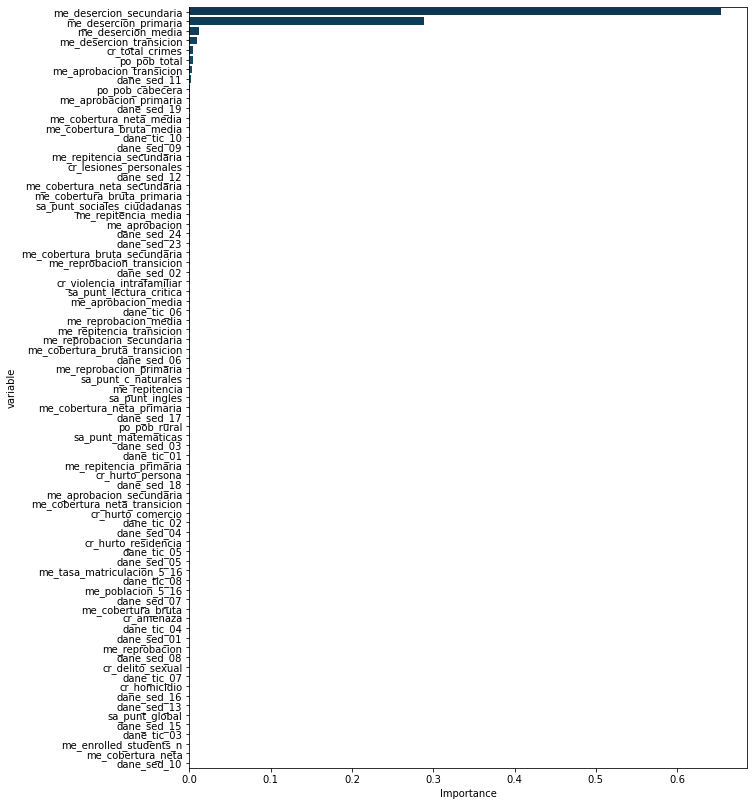

In [26]:
X_all=mun_nomiss.drop(vars_drop, axis=1)

y=mun_nomiss['desertion_perc']

# define the model
xgb_model = XGBRegressor()
# fit the model
xgb_model.fit(X_all, y)
# get importance
 
features_imp=dict(zip(X_all.columns, xgb_model.feature_importances_))
features_imp=pd.DataFrame.from_dict(features_imp, orient='index').reset_index()
features_imp.rename(columns={'index':'variable',0:'Importance'},inplace=True)
features_imp=features_imp.sort_values(by='Importance', ascending=False)
features_imp.to_clipboard(index=False,header=True)

plt.figure(figsize=(10,14))
ax = sns.barplot(x="Importance", y="variable", data=features_imp,palette="PuBu_r")


### Ajuste del modelo

In [116]:
feature_cols = ['me_desercion_secundaria','me_desercion_primaria','me_desercion_media','me_desercion_transicion','po_pob_total','cr_total_crimes']

X = X_all[feature_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

xgb1 = XGBRegressor()
parameters = {'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2),
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2]}

xgb_grid = GridSearchCV(xgb1,parameters,cv = 5,n_jobs = -1,verbose=False)

xgb_grid.fit(X_train,y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.9850067973303609
{'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1}


MAE train: 0.07243547185329456
MAE test: 0.15899776266217233
RMSE train: 0.09415071664369376
RMSE test: 0.2638882198314687
R-Squared train: 0.9971401256032681
R-Squared test: 0.9714036755229484


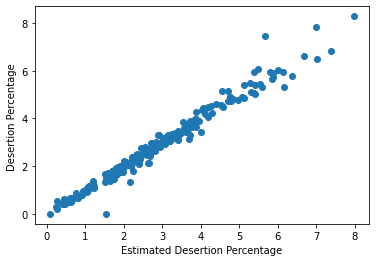

In [120]:
xbg_model = XGBRegressor(random_state=12345,learning_rate=0.2,max_depth=3,min_child_weight=1)
xbg_model = xbg_model.fit(X_train,y_train)
y_pred_train = xbg_model.predict(X_train)
y_pred_test = xbg_model.predict(X_test)

MAPE_train=np.mean(np.abs((y_train - y_pred_train) / (y_train))) * 100
MAPE_test=np.mean(np.abs((y_test - y_pred_test) / (y_test))) * 100
MAE_train=metrics.mean_absolute_error(y_train, y_pred_train)
MAE_test=metrics.mean_absolute_error(y_test, y_pred_test)
RMSE_train=np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
RMSE_test=np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
R2_train=metrics.r2_score(y_train, y_pred_train)
R2_test=metrics.r2_score(y_test, y_pred_test)

#print("MAPE train:",MAPE_train)
#print("MAPE test:",MAPE_test)
print("MAE train:",MAE_train)
print("MAE test:",MAE_test)
print("RMSE train:",RMSE_train)
print("RMSE test:",RMSE_test)
print("R-Squared train:",R2_train)
print("R-Squared test:",R2_test)

plt.scatter(y_pred_test, y_test)
plt.xlabel("Estimated Desertion Percentage")
plt.ylabel("Desertion Percentage ")
plt.show()
